In [1]:
import sklearn.datasets
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import time
import pickle

np.random.seed(1)
NUM_FEATURES = 784

TRAIN_SUBSET = 50000
TEST_SUBSET = 20000

In [2]:
dataset = sklearn.datasets.fetch_openml("mnist_784", version=1)

In [3]:
X = dataset.data.to_numpy()
y = dataset.target.to_numpy()

In [4]:
def randomVector(n):
    """
    Randomly generates hypervector of size n
    """
    return (2*np.random.randint(0, 2, n)) - 1

def bind(a, b):
    return np.multiply(a, b)

def randomFlip(vec, idxs):
    """
    Returns a vector with the inx bits flipped.
    """
    assert len(idxs) <= len(vec), "Number of bits to flip greater than vector length"
    
    flipped_vec = np.copy(vec)
    
    for i in idxs:
        flipped_vec[i] *= -1
        
    return flipped_vec
    
def cosSim(a, b):
    """
    Performs cosine similarity on vectors a and b
    """
    
    if norm(a) == 0 or norm(b) == 0:
        return 0
    else:
        return (np.dot(a, b) / (norm(a) * norm(b)))

def hammingDist(a, b):
    """
    Normalized hamming distance between two vectors.
    Vectors are assumed to be binarized.
    """
    assert len(a) == len(b), "Vectors are not the same length"
    #return hamming(a, b)
    return np.count_nonzero(a!=b) / len(a)

def compareVectors(X):
    """
    Generates a heatmap comparing each vector to all other vectors
    """
    mat = np.zeros((len(X), len(X)))
    for i, x1 in enumerate(X):
        for j, x2 in enumerate(X):
            mat[i][j] = hammingDist(x1, x2)
            
    return mat

In [5]:
def buildLevelVectors(levels, dim):
    """
    Level hypervectors, level hypervector at i is copied from level hypervector i-1 with D/(2*255) bits flipped
    """
    levelvectors = []
    min_vector = randomVector(dim)
    
    levelvectors.append(min_vector)
    
    window = 0
    indexes = np.arange(0, dim)
    np.random.shuffle(indexes)
    bit_flips = int(dim/(2*255))

    for i in range(1, levels):
        mid_vec = np.copy(levelvectors[i-1])
        mid_vec = randomFlip(mid_vec, indexes[window:window+bit_flips])
        window += bit_flips
        
        levelvectors.append(mid_vec)
        
    return np.array(levelvectors)

def buildPosVectors(n, dim):
    """
    Array of n random hypervectors to encode position of features.
    """
    posvectors = []
    for i in range(n):
        posvectors.append(randomVector(dim))
    return np.array(posvectors)

def rmrBinarize(x):
    """
    Random majority rule. 0 are randomly set to 1 or -1
    """
    h = [i/abs(i) if i != 0 else np.random.choice([-1.0, 1.0]) for i in x]
    return np.array(h)

def fmrBinarize(x, k):
    """
    Fixed majority rule. 0 are set to k
    """
    h = [i/abs(i) if i != 0 else k for i in x]
    return np.array(h)

In [6]:
class Encoder:
    def __init__(self, dim, n_features, binarizer):
        self.D = dim
        self.n_features = n_features
        self.B = buildPosVectors(n_features, dim)
        self.levelvectors = buildLevelVectors(256, dim)
        self.binarizer = binarizer        
        self.classvecs = {}
        
    def saveClasses(self):
        with open('classvectors.pickle', 'wb') as handle:
            pickle.dump(self.classvecs, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    def loadClasses(self):
        with open('classvectors.pickle', 'rb') as handle:
            self.classvecs = pickle.load(handle)
        
    def binarize(self, x):
        if self.binarizer == 'rmr':
            return rmrBinarize(x)
        else:
            return fmrBinarize(x, -1)
    
    def encodeVector(self, X):
        h = np.zeros(self.D)
        for i, feature in enumerate(X):
            h += bind(self.levelvectors[int(feature)], self.B[i])
        
        return self.binarize(h)
    
    def train(self, X, y):
        assert len(X) == len(y), "len(X) len(y) not equal"
        
        #Encode and add all train data
        for i, obs in enumerate(X):
            target = y[i]
            h = self.encodeVector(obs)
            if target not in self.classvecs.keys():
                self.classvecs[target] = h
            else:
                self.classvecs[target] += h
                
        #Binarize classvectors
        for key, val in self.classvecs.items():
            self.classvecs[key] = self.binarize(val)
                
    def predict(self, x):
        h = self.encodeVector(x)
        dists = {}
        min_dist = None
        min_key = None
        
        for key, val in self.classvecs.items():
            score = hammingDist(h, val)
            dists[key] = score
            if min_dist == None or min_dist > score:
                min_dist = score
                min_key = key
            
        return min_key, dists
    
    def predictAll(self, X, y):
        correct_matrix = np.zeros((10,10))
        acc = 0.0
        for i, x in enumerate(X):
            pred, _ = self.predict(x)
            if pred == y[i]:
                acc += 1.0
            correct_matrix[int(y[i])][int(pred)] += 1
        
        acc = acc / len(X)
        return acc, correct_matrix

In [7]:
encoder = Encoder(10240, NUM_FEATURES, 'rmr')

## Train from scratch

In [8]:
start = time.time()
encoder.train(X[0:TRAIN_SUBSET], y[0:TRAIN_SUBSET])
end = time.time()
print("%f seconds elapsed. Avg %f seconds per observation" % (end-start, (end-start) / TRAIN_SUBSET))

976.848971 seconds elapsed. Avg 0.019537 seconds per observation


## Load classvectors

In [20]:
encoder.loadClasses()

## Figure 2 from the paper

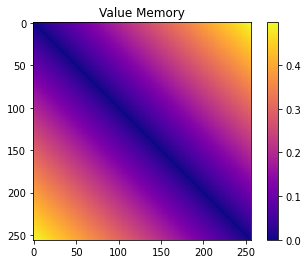

In [9]:
levelmat = compareVectors(encoder.levelvectors)
plt.imshow(levelmat, cmap='plasma', interpolation='nearest')
plt.title("Value Memory")
plt.colorbar()
plt.show()

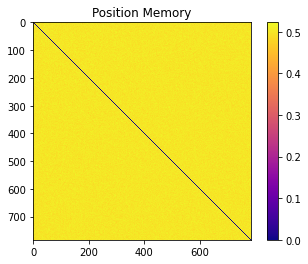

In [10]:
levelmat = compareVectors(encoder.B)
plt.imshow(levelmat, cmap='plasma', interpolation='nearest')
plt.title("Position Memory")
plt.colorbar()
plt.show()

In [11]:
acc, mat = encoder.predictAll(X[TRAIN_SUBSET:TRAIN_SUBSET+TEST_SUBSET], y[TRAIN_SUBSET:TRAIN_SUBSET+TEST_SUBSET])

Test Accuracy: 0.811


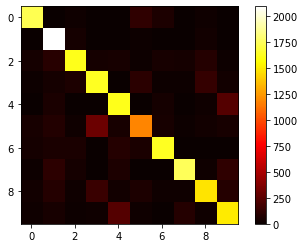

In [12]:
print(f"Test Accuracy: {acc}")
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [13]:
per_img_acc = np.zeros(len(mat))
for i in range(len(mat)):
    per_img_acc[i] = mat[i][i] / np.sum(mat[i])

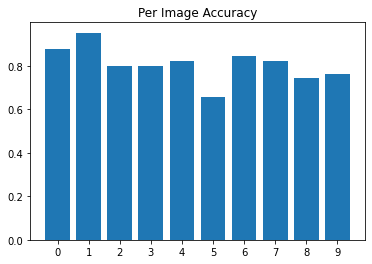

In [14]:
x_label = np.arange(0, 10)
plt.bar(x_label, per_img_acc)
plt.xticks(x_label)
plt.title("Per Image Accuracy")
plt.show()

In [15]:
encoder.saveClasses()